In [1]:
# !pip install salesforce-lavis

In [2]:
import pandas as pd
import numpy as np

import torch
from PIL import Image
from matplotlib import pyplot as plt

import random

In [3]:
from lavis.models import load_model_and_preprocess

from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam

In [4]:
root_path = '/home/smanduru/CS682Project/data/CUB_200_2011'

images_path = root_path + '/images'
attributes_path = root_path + '/attributes/'

In [5]:
images = []

with open(root_path + "/images.txt", "r") as file:
    
    for line in file:
        folder, image = line.strip().split('/')
        index, folder = folder.split(" ")
        images.append(images_path + '/' + folder + '/' + image)

In [6]:
len(images)

11788

In [7]:
data = pd.read_csv(attributes_path + "image_attribute_labels.txt", 
                   names=['img_index', 'attribute_index', 'attribute_value', 'certainity', 'unknown'],
                   delimiter=' ', on_bad_lines='warn')

In [8]:
data

,img_index,attribute_index,attribute_value,certainity,unknown
0,1,1,0,3,27.708
1,1,2,0,3,27.708
2,1,3,0,3,27.708
3,1,4,0,3,27.708
4,1,5,1,3,27.708
...,...,...,...,...,...
3677851,11788,308,1,4,4.989
3677852,11788,309,0,4,8.309
3677853,11788,310,0,4,8.309
3677854,11788,311,0,4,8.309


In [9]:
ranges = [(153, 167), (10, 24), (198, 212)] ## Forehead, Wing, Belly, Leg(264, 278)

df = data[data['attribute_value'] == 1]
df = df[df['attribute_index'].isin(sum([list(range(start, end + 1)) for start, end in ranges], []))]

In [10]:
df = df[['img_index', 'attribute_index', 'attribute_value']].reset_index(drop=True)

In [11]:
df

,img_index,attribute_index,attribute_value
0,1,165,1
1,2,15,1
2,2,158,1
3,2,166,1
4,2,210,1
...,...,...,...
49570,11788,164,1
49571,11788,165,1
49572,11788,203,1
49573,11788,204,1


In [12]:
attributes = {}
with open('/home/smanduru/CS682Project/data/attributes.txt' , "r") as file:
    
    for line in file:
        
        attribute_index, attribute = line.split()
        attribute_qsn, attribute_value = attribute.split('::')
        attribute_qsn = attribute_qsn.split('_', 1)[-1]
        attribute_qsn = attribute_qsn.replace('_', ' ')
        
        # print(attribute_index, attribute_qsn, attribute_value)
        attributes[attribute_index] = [int(attribute_index), attribute_qsn, attribute_value] 

In [13]:
att_df = pd.DataFrame.from_dict(attributes, orient='index', 
                                columns=['attribute_index', 'attribute_qsn', 'attribute_answer'])

In [14]:
att_df

,attribute_index,attribute_qsn,attribute_answer
1,1,bill shape,curved_(up_or_down)
2,2,bill shape,dagger
3,3,bill shape,hooked
4,4,bill shape,needle
5,5,bill shape,hooked_seabird
...,...,...,...
308,308,crown color,buff
309,309,wing pattern,solid
310,310,wing pattern,spotted
311,311,wing pattern,striped


In [15]:
merged_df = df.merge(att_df, how='inner', on='attribute_index')
merged_df = merged_df.sort_values(by=['img_index', 'attribute_index']).reset_index(drop = True)
merged_df

,img_index,attribute_index,attribute_value,attribute_qsn,attribute_answer
0,1,165,1,forehead color,white
1,2,15,1,wing color,grey
2,2,158,1,forehead color,grey
3,2,166,1,forehead color,red
4,2,210,1,belly color,white
...,...,...,...,...,...
49570,11788,164,1,forehead color,black
49571,11788,165,1,forehead color,white
49572,11788,203,1,belly color,grey
49573,11788,204,1,belly color,yellow


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

answer_candidates = ["blue", "brown", "iridescent", "purple",
                     "rufous", "grey", "yellow", "olive",
                     "green", "pink", "orange", "black",
                     "white", "red", "buff"]

In [17]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_vqa",
                                                                  model_type = "vqav2",
                                                                  is_eval=True,
                                                                  device=device)

In [18]:
# for row in merged_df.iterrows():
    
#     img_path = images[int(row[1]['img_index']) - 1]
#     raw_image = Image.open(img_path).convert("RGB")
    
#     # display(raw_image.resize((596, 437)))
#     question = f"What is the {row[1]['attribute_qsn']} of the bird?"
    
#     image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
#     question = txt_processors["eval"](question)

#     samples = {"image": image, "text_input": question}
    
#     print(model.predict_answers(samples, answer_list=answer_candidates, inference_method="rank"))
#     print(row[1]['attribute_answer'])
#     break

In [19]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

In [20]:
class MyDataset(Dataset):
    def __init__(self, images, image_indexes, questions, answers, transform=None):
        self.images = images
        self.questions = questions
        self.transform = transform
        self.image_indexes = image_indexes
        self.answers = answers

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        img_index = self.image_indexes[idx]
        img_path = images[int(img_index) - 1]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        question_part = self.questions[idx]
        question = f"What is the {question_part} of the bird?"
        
        answer = self.answers[idx]
        
        return {'image': img, 'question': question, 'answer': answer}

In [21]:
image_indexes = merged_df['img_index'].to_list()  # List of image paths
questions = merged_df['attribute_qsn'].to_list() # List of questions
answers = merged_df['attribute_answer'].to_list()

# Define image transformations (replace with your actual transformations)
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Create an instance of the dataset
dataset = MyDataset(images, image_indexes, questions, answers, transform)

In [22]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
len(dataloader)

369

In [24]:
total_correct = total_samples = 0

for i, batch in enumerate(dataloader):
    images_batch = batch['image']
    questions_batch = batch['question']
    
    
    # Process each image and question in the batch
    processed_images_batch = [vis_processors["eval"](to_pil_image(image)).unsqueeze(0).to(device) for image in images_batch]
    processed_questions_batch = [txt_processors["eval"](question) for question in questions_batch]
    
    # print(processed_images_batch, processed_questions_batch)
    concatenated_images = torch.stack(processed_images_batch)

    reshaped_images_batch = torch.reshape(concatenated_images, (len(processed_images_batch), 3, 480, 480))

    
    # Use the model to predict answers
    predictions = model.predict_answers(samples={"image": reshaped_images_batch,
                                                 "text_input": processed_questions_batch},
                                        answer_list=answer_candidates,
                                        inference_method="rank")
        
    
    ground_truth_answers = batch['answer']
    
    # Calculate accuracy for this batch
    correct_predictions = sum([1 for pred, truth in zip(predictions, ground_truth_answers) if pred == truth])
    total_correct += correct_predictions
    total_samples += len(processed_images_batch)
    

accuracy = total_correct / total_samples


In [25]:
accuracy

0.412368510349508

# Plot utilities for GradCam

In [47]:
model, vis_processors, text_processors = load_model_and_preprocess("blip_image_text_matching",
                                                                   "large",
                                                                   device=device, is_eval=True)

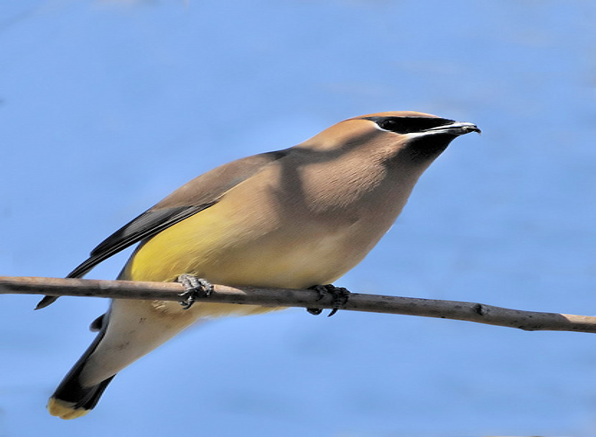

In [70]:
img_path = random.choice(images)

raw_image = Image.open(img_path).convert("RGB")
display(raw_image.resize((596, 437)))

In [73]:
index = images.index(img_path)
index #4896 #10876

10876

In [74]:
merged_df[merged_df['img_index'] == index]

,img_index,attribute_index,attribute_value,attribute_qsn,attribute_answer
45542,10876,15,1,wing color,grey
45543,10876,163,1,forehead color,orange
45544,10876,212,1,belly color,buff


In [75]:
attributes_qsn = merged_df[merged_df['img_index'] == index]['attribute_qsn'].to_list()
captions = [f"{attribute} of the bird" for attribute in attributes_qsn]

captions

['wing color of the bird',
 'forehead color of the bird',
 'belly color of the bird']

In [76]:
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255

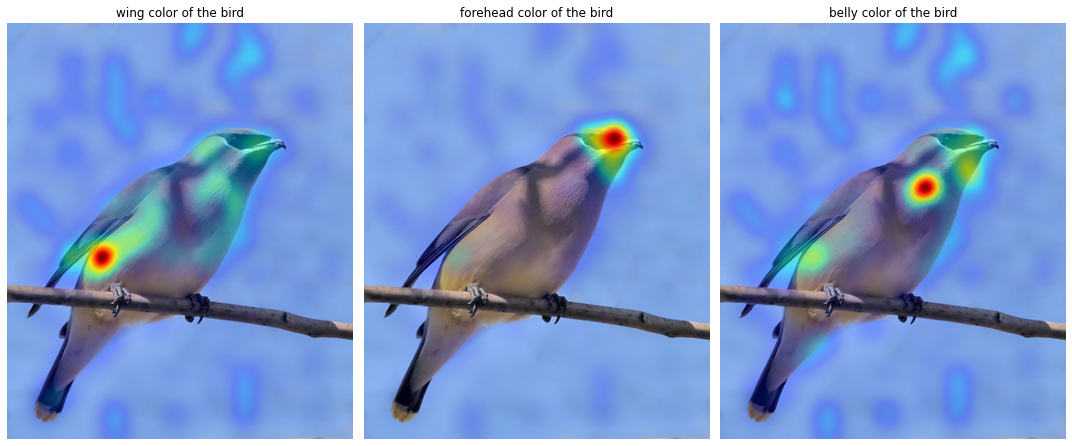

In [77]:
gradcams = []

# Iterate over captions to compute GradCAMs and average GradCAMs
for caption in captions:
    img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    txt = text_processors["eval"](caption)
    
    txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
    gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
    
    avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True)
    gradcams.append(avg_gradcam)

# Plot all captions with their average GradCAMs
fig, ax = plt.subplots(1, len(captions), figsize=(15, 10 * len(captions)))

for i, (caption, avg_gradcam) in enumerate(zip(captions, gradcams)):
    avg_gradcam = (avg_gradcam - avg_gradcam.min()) / (avg_gradcam.max() - avg_gradcam.min())
    ax[i].set_title(caption)
    ax[i].imshow(avg_gradcam)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

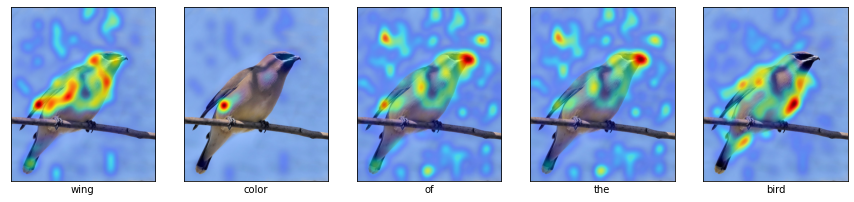

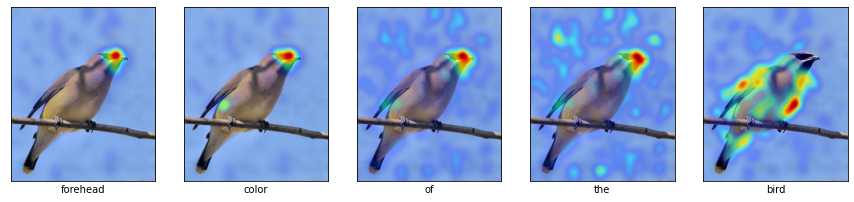

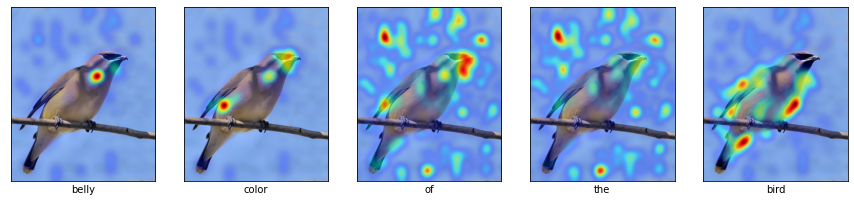

In [78]:
for caption in captions:
    img = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    txt = text_processors["eval"](caption)
    
    txt_tokens = model.tokenizer(txt, return_tensors="pt").to(device)
    gradcam, _ = compute_gradcam(model, img, txt, txt_tokens, block_num=7)
    
    num_image = len(txt_tokens.input_ids[0]) - 2
    fig, ax = plt.subplots(1, num_image, figsize=(15, 5 * num_image))

    gradcam_iter = iter(gradcam[0][2:-1])
    token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

    for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
        word = model.tokenizer.decode([token_id])
        gradcam_image = getAttMap(norm_img, gradcam, blur=True)
        gradcam_image = (gradcam_image - gradcam_image.min()) / (gradcam_image.max() - gradcam_image.min())
        ax[i].imshow(gradcam_image)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_xlabel(word)